In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the Vector Quantizer
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self.num_embeddings = num_embeddings  # Size of the codebook
        self.embedding_dim = embedding_dim    # Dimension of each codebook vector
        self.commitment_cost = commitment_cost  # Weight for commitment loss
        
        # Create the codebook as a learnable parameter
        # This is our "visual vocabulary"
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.codebook.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        
    def forward(self, inputs):
        # Convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances between input vectors and codebook vectors
        # For each input vector, find the closest codebook entry
        distances = torch.sum(flat_input**2, dim=1, keepdim=True) + \
                    torch.sum(self.codebook.weight**2, dim=1) - \
                    2 * torch.matmul(flat_input, self.codebook.weight.t())
        
        # Find nearest encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.codebook.weight).view(input_shape)
        
        # Calculate loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)  # Encoder loss
        q_latent_loss = F.mse_loss(quantized, inputs.detach())  # Codebook loss
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        # Straight-through estimator
        quantized = inputs + (quantized - inputs).detach()
        
        # Convert quantized from BHWC -> BCHW
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        return quantized, loss, encoding_indices.view(input_shape[:-1])

In [5]:
# Define the Encoder
class Encoder(nn.Module):
    def __init__(self, in_channels, hidden_dims, embedding_dim):
        super(Encoder, self).__init__()
        
        modules = []
        
        # Simple convolutional architecture
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU()
                )
            )
            in_channels = h_dim
        
        # Final layer
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, embedding_dim,
                          kernel_size=1, stride=1),
                nn.BatchNorm2d(embedding_dim)
            )
        )
        
        self.encoder = nn.Sequential(*modules)
        
    def forward(self, x):
        encoding = self.encoder(x)
        # Store the spatial(HxW) dimensions for the decoder
        self.output_dims = encoding.shape[2:]
        return encoding

In [6]:
# Define the Decoder
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dims, out_channels):
        super(Decoder, self).__init__()
        
        modules = []
        
        # Initial layer - no upsampling yet
        modules.append(
            nn.Sequential(
                nn.Conv2d(embedding_dim, hidden_dims[-1],
                          kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU()
            )
        )
        
        # Upsampling layers
        for i in range(len(hidden_dims) - 1, 0, -1):
            modules.append(
                nn.Sequential(
                    # Ensure proper upsampling with output_padding when needed
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i-1],
                                      kernel_size=3, stride=2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i-1]),
                    nn.LeakyReLU()
                )
            )
        
        # Final layer
        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(hidden_dims[0], out_channels,
                                  kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.Tanh()
            )
        )
        
        self.decoder = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.decoder(x)

In [7]:
# Define the Discriminator for GAN component
class Discriminator(nn.Module):
    def __init__(self, in_channels, hidden_dims):
        super(Discriminator, self).__init__()
        
        modules = []
        
        # Simple convolutional architecture
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size=4, stride=2, padding=1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(0.2)
                )
            )
            in_channels = h_dim
        
        # Final layer
        modules.append(
            nn.Sequential(
                nn.Conv2d(in_channels, 1,
                          kernel_size=3, stride=1, padding=0),
                nn.Sigmoid()
            )
        )
        
        self.discriminator = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.discriminator(x)

In [8]:
# Define the complete VQGAN model
class VQGAN(nn.Module):
    def __init__(self, in_channels, hidden_dims, num_embeddings, embedding_dim, commitment_cost, img_size=28):
        super(VQGAN, self).__init__()
        
        self.encoder = Encoder(in_channels, hidden_dims, embedding_dim)
        self.vector_quantizer = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
        self.decoder = Decoder(embedding_dim, hidden_dims, in_channels)
        self.discriminator = Discriminator(in_channels, hidden_dims)
        
    def forward(self, x):
        # Store original size for resizing output if needed
        original_size = x.shape[2:]
        
        z = self.encoder(x)
        quantized, vq_loss, encoding_indices = self.vector_quantizer(z)
        x_recon = self.decoder(quantized)
        
        # Ensure output size matches input size
        if x_recon.shape[2:] != original_size:
            x_recon = F.interpolate(x_recon, size=original_size, mode='bilinear', align_corners=False)
            
        return x_recon, vq_loss, encoding_indices
    
    def encode(self, x):
        z = self.encoder(x)
        quantized, _, encoding_indices = self.vector_quantizer(z)
        return encoding_indices
    
    def decode(self, encoding_indices):
        # Convert indices to one-hot encodings
        encodings = F.one_hot(encoding_indices, self.vector_quantizer.num_embeddings).float()
        
        # Get quantized vectors from the codebook
        quantized = torch.matmul(encodings, self.vector_quantizer.codebook.weight)
        
        # Reshape to match the encoder output shape
        quantized = quantized.permute(0, 3, 1, 2).contiguous()
        
        # Decode
        x_recon = self.decoder(quantized)

        if x_recon.shape[2:] != (self.img_size, self.img_size):
            x_recon = F.interpolate(x_recon, size=(self.img_size, self.img_size), 
                                   mode='bilinear', align_corners=False)
        return x_recon

In [13]:
# Function to train the model
def train_vqgan(model, dataloader, num_epochs=10, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Optimizers
    optimizer = optim.Adam(
        list(model.encoder.parameters()) +
        list(model.decoder.parameters()) +
        list(model.vector_quantizer.parameters()), lr=learning_rate)

    disc_optimizer = optim.Adam(model.discriminator.parameters(), lr=learning_rate * 0.5)  # slower LR for D

    # Loss functions
    recon_loss_fn = nn.MSELoss()
    gan_loss_fn = nn.BCELoss()

    # Loss weights
    recon_loss_weight = 1.0
    vq_loss_weight = 1.0
    gan_loss_weight = 0.1

    for epoch in range(num_epochs):
        model.train()
        total_g_loss = 0
        total_d_loss = 0

        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)

            ### ----- Train Generator -----
            optimizer.zero_grad()
            reconstructions, vq_loss, _ = model(data)

            # Loss components
            recon_loss = recon_loss_fn(reconstructions, data)
            disc_fake = model.discriminator(reconstructions)
            real_labels = torch.full_like(disc_fake, 0.9)  # label smoothing
            gan_loss = gan_loss_fn(disc_fake, real_labels)

            # Combined generator loss
            g_loss = (recon_loss_weight * recon_loss +
                      vq_loss_weight * vq_loss +
                      gan_loss_weight * gan_loss)

            g_loss.backward()
            optimizer.step()

            ### ----- Train Discriminator every 2 steps -----
            if batch_idx % 2 == 0:
                disc_optimizer.zero_grad()

                disc_real = model.discriminator(data)
                disc_fake = model.discriminator(reconstructions.detach())

                real_labels = torch.full_like(disc_real, 0.9)
                fake_labels = torch.full_like(disc_fake, 0.1)

                d_real_loss = gan_loss_fn(disc_real, real_labels)
                d_fake_loss = gan_loss_fn(disc_fake, fake_labels)
                d_loss = (d_real_loss + d_fake_loss) / 2

                d_loss.backward()
                disc_optimizer.step()
            else:
                d_loss = torch.tensor(0.0)  # placeholder if D not trained

            total_g_loss += g_loss.item()
            total_d_loss += d_loss.item()

            if batch_idx % 100 == 0:
                print(f"Epoch: {epoch}, Batch: {batch_idx}, "
                      f"G Loss: {g_loss.item():.4f} "
                      f"(Recon: {recon_loss.item():.4f}, VQ: {vq_loss.item():.4f}, GAN: {gan_loss.item():.4f}), "
                      f"D Loss: {d_loss.item():.4f}")

        avg_g_loss = total_g_loss / len(dataloader)
        avg_d_loss = total_d_loss / (len(dataloader) // 2)
        print(f"Epoch: {epoch}, Avg G Loss: {avg_g_loss:.4f}, Avg D Loss: {avg_d_loss:.4f}")

        # Save some reconstructed images
        if epoch % 5 == 0:
            model.eval()
            with torch.no_grad():
                sample = next(iter(dataloader))[0][:8].to(device)
                recon, _, _ = model(sample)
                comparison = torch.cat([sample, recon], dim=0)
                save_image(comparison.cpu(), f'reconstruction_epoch_{epoch}.png', nrow=8)

    return model

In [14]:
# Main function to set up and run the training
def main():
    # Set up parameters
    batch_size = 64
    hidden_dims = [32, 64, 128]
    num_embeddings = 512  # Size of the codebook
    embedding_dim = 64    # Dimension of each codebook vector
    commitment_cost = 0.25
    num_epochs = 20
    img_size = 28
    
    # Load the MNIST dataset for simplicity
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    
    # Initialize the model
    model = VQGAN(in_channels=1,  # MNIST is grayscale
                  hidden_dims=hidden_dims,
                  num_embeddings=num_embeddings,
                  embedding_dim=embedding_dim,
                  commitment_cost=commitment_cost,
                  img_size=img_size)
    
    # Train the model
    trained_model = train_vqgan(model, train_loader, num_epochs=num_epochs)
    
    # Save the model
    torch.save(trained_model.state_dict(), 'vqgan_mnist.pth')
    
    # Generate some samples
    trained_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Visualize some reconstructions
    with torch.no_grad():
        sample = next(iter(train_loader))[0][:16].to(device)
        recon, _, _ = trained_model(sample)
        
        # Create a figure to visualize
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        
        # Display original images
        for i in range(16):
            ax = axes[i // 8, i % 8]
            ax.imshow(sample[i].cpu().numpy().squeeze(), cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title('Original')
        
        # Display reconstructed images
        for i in range(16):
            ax = axes[2 + i // 8, i % 8]
            ax.imshow(recon[i].cpu().numpy().squeeze(), cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title('Reconstructed')
        
        plt.tight_layout()
        plt.savefig('vqgan_samples.png')
        plt.close()
    
    # Visualize the codebook
    with torch.no_grad():
        # Get the codebook
        codebook = trained_model.vector_quantizer.codebook.weight.data
        
        # Create a grid to visualize some codebook entries
        grid_size = min(16, num_embeddings)
        fig, axes = plt.subplots(4, 4, figsize=(8, 8))
        
        for i in range(grid_size):
            ax = axes[i // 4, i % 4]
            # Reshape the embedding to a square for visualization
            size = int(np.sqrt(embedding_dim))
            code = codebook[i].reshape(size, size).cpu().numpy()
            ax.imshow(code, cmap='viridis')
            ax.axis('off')
            ax.set_title(f'Code {i}')
        
        plt.tight_layout()
        plt.savefig('codebook_visualization.png')
        plt.close()

if __name__ == "__main__":
    main()

Epoch: 0, Batch: 0, G Loss: 2.2119 (Recon: 0.8977, VQ: 1.2489, GAN: 0.6519), D Loss: 0.7599
Epoch: 0, Batch: 100, G Loss: 1.6617 (Recon: 0.3602, VQ: 1.2404, GAN: 0.6110), D Loss: 0.8998
Epoch: 0, Batch: 200, G Loss: 1.5646 (Recon: 0.2811, VQ: 1.2280, GAN: 0.5552), D Loss: 0.8844
Epoch: 0, Batch: 300, G Loss: 1.5184 (Recon: 0.2352, VQ: 1.2186, GAN: 0.6458), D Loss: 0.7975
Epoch: 0, Batch: 400, G Loss: 1.4697 (Recon: 0.1927, VQ: 1.2123, GAN: 0.6477), D Loss: 0.7323
Epoch: 0, Batch: 500, G Loss: 1.4599 (Recon: 0.1825, VQ: 1.2070, GAN: 0.7039), D Loss: 0.7066
Epoch: 0, Batch: 600, G Loss: 1.4543 (Recon: 0.1755, VQ: 1.2049, GAN: 0.7390), D Loss: 0.6692
Epoch: 0, Batch: 700, G Loss: 1.4458 (Recon: 0.1680, VQ: 1.2036, GAN: 0.7416), D Loss: 0.6640
Epoch: 0, Batch: 800, G Loss: 1.4451 (Recon: 0.1702, VQ: 1.2022, GAN: 0.7268), D Loss: 0.6553
Epoch: 0, Batch: 900, G Loss: 1.4422 (Recon: 0.1655, VQ: 1.2020, GAN: 0.7462), D Loss: 0.6522
Epoch: 0, Avg G Loss: 1.5187, Avg D Loss: 0.7434
Epoch: 1, Bat

In [15]:
model = VQGAN(in_channels=1, hidden_dims=[32, 64, 128],
              num_embeddings=512, embedding_dim=64,
              commitment_cost=0.25, img_size=28)

model.load_state_dict(torch.load('vqgan_mnist.pth'))
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/tmp/ipykernel_31/3149222259.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('vqgan_mnist.pth'))


VQGAN(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (v

In [17]:
from PIL import Image
from torchvision import transforms

# Load image
img_path = '/kaggle/input/image-try/Example-of-a-MNIST-input-An-image-is-passed-to-the-network-as-a-matrix-of-28-by-28.png'  # Make sure it's a grayscale 28x28 image
image = Image.open(img_path).convert('L')  # Convert to grayscale

# Apply the same transforms used during training
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
input_tensor.shape

torch.Size([1, 1, 28, 28])

In [18]:
with torch.no_grad():
    reconstructed, _, _ = model(input_tensor)

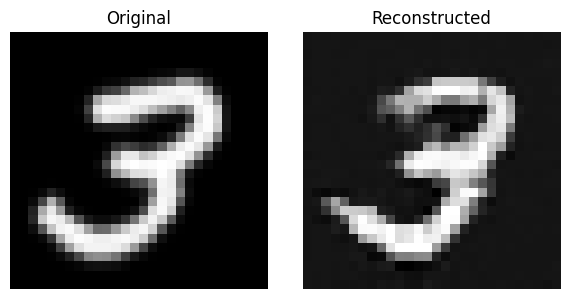

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# Original
ax[0].imshow(input_tensor.squeeze().cpu().numpy(), cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Reconstructed
ax[1].imshow(reconstructed.squeeze().cpu().numpy(), cmap='gray')
ax[1].set_title('Reconstructed')
ax[1].axis('off')

plt.tight_layout()
plt.show()